# final_analysis.py.ipynb
This notebook plots the figures for the manuscript. It starts with a single source of input data (`integrate_data.csv`). We restrict the analysis to our sample of interest (cells infected by a WT virus). Then, we calculate the necessary outcome metrics and plot the outcomes of infection.

Import Python modules:

In [1]:
from IPython.display import display
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotnine as p9
import subprocess
from svgutils.compose import *

Set the theme for plots:

In [2]:
p9.theme_set(p9.theme_classic())
CBPALETTE = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

Set output folder for figures:

In [3]:
figure_dir = 'results/figures'
if not os.path.exists(figure_dir):
    # Create a new directory because it does not exist 
    os.makedirs(figure_dir)
    print(f"Made `{figure_dir}` directory ")
else:
    print(f"Directory `{figure_dir}` already exists.")

Directory `results/figures` already exists.


## Read input data
The general structure of the `integrated_data_csv` file is that each cell barcode is listed on a row, and features of that cell are listed in columns. Cells that have more than one valid viral barcode identified may have multiple rows--one for each valid viral barcode.

In [4]:
integrated_data_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_integrate_data.csv'
integrated_data = pd.read_csv(integrated_data_csv)
integrated_data

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,barcoded_gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,freq_second_infection,freq_supernatant,max_freq_second_infection,max_freq_supernatant,contributes_progeny_second_infection,contributes_progeny_supernatant
0,AAACCCAGTAACAAGT,uninfected,none,47873,6,0.000125,0,2,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAACCCATCATTGCTT,uninfected,none,90114,10,0.000111,1,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAACGAAAGATGTTGA,uninfected,none,111630,18,0.000161,0,3,10,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACGAAGTACTTCCC,infected,both,56828,24082,0.423770,7,2,13060,420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,8,319,1582,31,...,fluHA,AAGTAAGCGACATGAG,251.0,0.002019,0.000010,0.000076,0.000010,0.000076,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3677,TTTGATCTCCCGTTCA,uninfected,none,63150,3,0.000048,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3678,TTTGGAGAGTTGCCTA,uninfected,none,65941,12,0.000182,1,0,6,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3679,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486,8,93,1668,45,...,fluHA,AGTAAACTTCCTCGCG,65.0,0.000433,0.000010,0.000695,0.000028,0.001790,True,True
3680,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486,8,93,1668,45,...,fluNA,ACATCTTATTTACACG,39.0,0.000260,0.000028,0.001790,0.000028,0.001790,True,True


### Combine data for each cell into single row
Process the dataframe so that each cell becomes a single row. Progeny contributions are summed for each cell, source, and barcoded gene (e.g. supernatant_freq_fluHA) and listed in a column.

In [5]:
min_viral_barcode_freq = 1e-5  # value assigned to unobserved viral barcodes

# aggregate observed viral barcodes for each gene and cell
processed_data = (
    integrated_data
    .groupby(["cell_barcode", "barcoded_gene"], as_index=False)
    .aggregate(
        n_viral_barcodes=pd.NamedAgg("viral_barcode", lambda v: v.astype(bool).astype(int).sum()),
        viral_barcodes=pd.NamedAgg("viral_barcode", "; ".join),
        freq_supernatant=pd.NamedAgg("freq_supernatant", "sum"),
        freq_second_infection=pd.NamedAgg("freq_second_infection", "sum"),
    )
)
assert processed_data.notnull().all().all()

# get barcoded viral genes
barcoded_genes = processed_data["barcoded_gene"].unique().tolist()

# now pivot so just one row per cell
pivoted_dfs = []
for col_to_pivot, fill_value in [
    ("n_viral_barcodes", 0),
    ("viral_barcodes", ""),
    ("freq_supernatant", pd.NA),
    ("freq_second_infection", pd.NA),
]:
    pivoted_dfs.append(
        processed_data
        .pivot_table(
            index="cell_barcode",
            columns="barcoded_gene",
            values=col_to_pivot,
            fill_value=fill_value,
            aggfunc='sum',
        )
        .rename_axis(None, axis=1)
        .rename(columns={gene: f"{col_to_pivot}_{gene}" for gene in barcoded_genes})
    )
assert all((pivoted_dfs[0].index == df.index).all() for df in pivoted_dfs)
processed_data = pd.concat(pivoted_dfs, axis=1).reset_index()

# now add back in cell-specific information
# Require infected cells since the above measurements only make sense for
# infected cells.
cell_info = (
    integrated_data
    [['cell_barcode', 'infected', 'infecting_viral_tag', 'total_UMIs',
       'viral_UMIs', 'frac_viral_UMIs', 'n_viral_genes'] +
     [c for c in integrated_data.columns
      if re.match("transcriptome_UMIs_flu|frac_UMIs_flu|present_flu|pacbio_UMIs|mutations_|mutation_support_", c)]
    ]
    .drop_duplicates()
)

assert set(processed_data["cell_barcode"]).issubset(cell_info["cell_barcode"])
processed_data = (
    cell_info.query('infected == "infected"')
    .merge(processed_data, on="cell_barcode", how="left", validate="one_to_one")
)

# add columns explaining missing genes
present_columns = {c: c.replace("present_flu", "") for c in processed_data.columns
                   if re.match("present_flu", c)}

processed_data = (
    processed_data
    .assign(
        all_viral_genes=lambda x: x['n_viral_genes'] == len(present_columns),
        missing_viral_genes=lambda x: x.apply(lambda row:
            "; ".join(val for (key, val) in present_columns.items() if not row[key]),
            axis=1)
    )
)

# check for complete pacbio data for all expressed viral genes
def virus_fully_sequenced(row):
    row_dict = row.to_dict()
    for key, val in row_dict.items():
        if re.fullmatch("present_flu\w+", key) and val:
            gene = key.split("_")[1]
            if row_dict[f"pacbio_UMIs_{gene}"] < 2:
                return False
    else:
        return True

processed_data = (
    processed_data
    .assign(virus_fully_sequenced=lambda x: x.apply(virus_fully_sequenced, axis=1))
)

# check to see if cell expresses both barcoded viral genes
processed_data["all_barcoded_genes"] = np.logical_and.reduce(
    [processed_data[f"present_{gene}"] for gene in barcoded_genes] +
    [processed_data[f"freq_supernatant_{gene}"].notnull() for gene in barcoded_genes] +
    [processed_data[f"freq_second_infection_{gene}"].notnull() for gene in barcoded_genes]
)

# annotate cells with both complete pacbio data and both barcoded viral genes
def sequenced_and_barcoded(row):
    if row['virus_fully_sequenced'] and row['all_barcoded_genes']:
        return "sequenced and barcoded"
    elif row['virus_fully_sequenced']:
        return "sequenced"
    elif row['all_barcoded_genes']:
        return "barcoded"
    else:
        return "not sequenced or barcoded"
processed_data["sequenced_and_barcoded"] = (
    processed_data.apply(sequenced_and_barcoded, axis=1)
)

display(processed_data)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,viral_barcodes_fluNA,freq_supernatant_fluHA,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded
0,AAACGAAGTACTTCCC,infected,both,56828,24082,0.423770,7,2,13060,420,...,NaN,NaN,NaN,NaN,NaN,False,HA,True,False,sequenced
1,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,8,319,1582,31,...,GTAGGCGATAAGTGGA,0.000076,0.000076,0.00001,0.00001,True,,False,True,barcoded
2,AAAGGATTCTGATGGT,infected,syn,80029,3893,0.048645,8,281,1099,738,...,TGTTATATTTGTATTG,0.00001,0.013183,0.00001,0.077933,True,,False,True,barcoded
3,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,23,...,CTCGTTTTCGGAGTAC; GACTATCTAATTGAGG,0.003532,0.000135,0.000165,0.00002,False,PA,True,True,sequenced and barcoded
4,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,82,...,TTTACTTTAAGTGCTT,0.00001,0.00001,0.00001,0.00001,True,,True,True,sequenced and barcoded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,71,...,TAAAAAATGTCTCATG,0.001014,0.001284,0.000154,0.000015,True,,True,True,sequenced and barcoded
406,TTGGGATTCCGATTAG,infected,syn,137623,6652,0.048335,8,262,3656,48,...,GTTTCGTGAGCATGTA,0.00001,0.00001,0.00001,0.00001,True,,True,True,sequenced and barcoded
407,TTTACCAGTCGCTTAA,infected,wt,114567,1434,0.012517,7,125,609,15,...,ATTTGGATGTAGGGGC; TTGGAGGAGACCCGTG,0.000106,0.001222,0.00002,0.000029,False,PA,False,True,barcoded
408,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,219,...,GGTATCAGTTATTGTT,0.00001,0.00001,0.00001,0.00001,False,NS; PB1,True,True,sequenced and barcoded


## Restrict analysis to WT infected cells
We only want to plot our sample of interest, which is made up of cells infected by a WT virus. We will exclude uninfected cells, infected multiplets (transcriptomes derived from both WT and dblSyn cells), and infected dblSyn cells.

In [6]:
wt_infected_cells = (
    processed_data
    .query('infected == "infected" and infecting_viral_tag == "wt"'))
wt_infected_cells

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,viral_barcodes_fluNA,freq_supernatant_fluHA,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded
1,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,8,319,1582,31,...,GTAGGCGATAAGTGGA,0.000076,0.000076,0.00001,0.00001,True,,False,True,barcoded
3,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,23,...,CTCGTTTTCGGAGTAC; GACTATCTAATTGAGG,0.003532,0.000135,0.000165,0.00002,False,PA,True,True,sequenced and barcoded
4,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,82,...,TTTACTTTAAGTGCTT,0.00001,0.00001,0.00001,0.00001,True,,True,True,sequenced and barcoded
5,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,4204,...,AGTTATTGGTTGGATA,0.00002,0.000971,0.00002,0.000022,True,,True,True,sequenced and barcoded
7,AACTTCTGTGAGACGT,infected,wt,137078,2955,0.021557,8,100,845,8,...,GATAAGTATGACAAAG,0.00001,0.00001,0.00001,0.00001,True,,False,True,barcoded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,30,...,GAGCTCCTGTATTGCC,0.00001,0.00001,0.00001,0.00001,False,PA,True,True,sequenced and barcoded
405,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,71,...,TAAAAAATGTCTCATG,0.001014,0.001284,0.000154,0.000015,True,,True,True,sequenced and barcoded
407,TTTACCAGTCGCTTAA,infected,wt,114567,1434,0.012517,7,125,609,15,...,ATTTGGATGTAGGGGC; TTGGAGGAGACCCGTG,0.000106,0.001222,0.00002,0.000029,False,PA,False,True,barcoded
408,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,219,...,GGTATCAGTTATTGTT,0.00001,0.00001,0.00001,0.00001,False,NS; PB1,True,True,sequenced and barcoded


In [7]:
n_wt_infected_cells = wt_infected_cells["cell_barcode"].nunique()
print(f'There are {n_wt_infected_cells} cells in the dataset.')

There are 254 cells in the dataset.


## Plot viral transcription
I will plot the histogram of viral transcription. I need to know where to set the limits and bins, so I will look up the maximum viral transcription fraction for these data.

In [8]:
print(f'The maximum fraction of viral transcription '
      f'in an infected cells is {wt_infected_cells["frac_viral_UMIs"].max()}')

The maximum fraction of viral transcription in an infected cells is 0.6711695819913736


/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 4 x 1.5 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/viral_transcription.svg


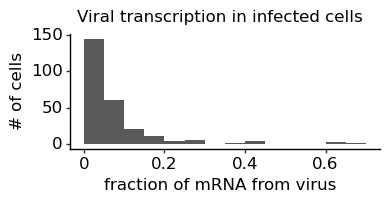

<ggplot: (8765064164934)>

In [9]:
viral_transcription_file = figure_dir+'/'+'viral_transcription.svg'

viral_transcription_plot = (
    p9.ggplot(
        wt_infected_cells,
        p9.aes(x='frac_viral_UMIs')) +
    p9.geom_histogram(breaks=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,
                              0.4,0.45,0.5,0.55,0.6,0.65,0.7]) +
    p9.ggtitle(f'Viral transcription in infected cells') +
    p9.labs(x='fraction of mRNA from virus',
            y='# of cells') +
    p9.theme(figure_size=(4, 1.5),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=12, color="black")))
viral_transcription_plot.save(filename = viral_transcription_file)
display(viral_transcription_plot)

### Plot viral genes per infected cell

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 1.5 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/genes_per_cell.svg


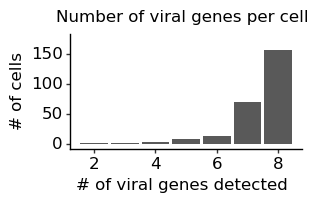

<ggplot: (8765064090477)>

In [10]:
genes_per_cell_file = figure_dir+'/'+'genes_per_cell.svg'

genes_per_cell_plot = (
    p9.ggplot(
        wt_infected_cells[['cell_barcode', 'n_viral_genes']].drop_duplicates(),
        p9.aes(x='n_viral_genes')) +
    p9.geom_bar(stat='count', position='dodge') +
    p9.ggtitle('Number of viral genes per cell') +
    p9.labs(x='# of viral genes detected',
            y='# of cells') +
    p9.scale_y_continuous(limits=[0,175], breaks=[0,50,100,150]) +
    p9.theme(figure_size=(3, 1.5),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=12),
                axis_text=p9.element_text(size=12, color="black")))
genes_per_cell_plot.save(filename = genes_per_cell_file)
display(genes_per_cell_plot)

### Plot viral gene presence or absence

To generate this plot, I need to tabulate how many cells express or do not express each viral gene. I will make a new dataframe with cell barcode, frac_viral_UMIs, and gene as columns. For each cell, I will list whether the gene is present and the fraction of gene UMIs in the cell.

In [11]:
gene_present_by_cell = (
    wt_infected_cells
    [['cell_barcode',
      'present_fluPB2', 'present_fluPB1',
      'present_fluPA', 'present_fluHA',
      'present_fluNP', 'present_fluNA',
      'present_fluM', 'present_fluNS']]
    .drop_duplicates()
    .melt(
        id_vars=['cell_barcode'],
        var_name='gene',
        value_name='gene_present')
)
gene_present_by_cell['gene'] = (
    gene_present_by_cell['gene']
    .str.split('_').str[-1])

gene_frac_by_cell = (
    wt_infected_cells
    [['cell_barcode', 'frac_viral_UMIs',
      'frac_UMIs_fluPB2', 'frac_UMIs_fluPB1',
      'frac_UMIs_fluPA', 'frac_UMIs_fluHA',
      'frac_UMIs_fluNP', 'frac_UMIs_fluNA',
      'frac_UMIs_fluM', 'frac_UMIs_fluNS']]
    .drop_duplicates()
    .melt(
        id_vars=['cell_barcode', 'frac_viral_UMIs'],
        var_name='gene',
        value_name='frac_gene_UMIs')
)
gene_frac_by_cell['gene'] = (
    gene_frac_by_cell['gene']
    .str.split('_').str[-1])

viral_genes_by_cell = pd.merge(
    left=gene_present_by_cell,
    right=gene_frac_by_cell,
    on=['cell_barcode','gene'],
    how='outer'
)
viral_genes_by_cell['gene'] = (
    viral_genes_by_cell['gene']
    .replace(['fluPB2', 'fluPB1', 'fluPA', 'fluHA',
              'fluNP', 'fluNA', 'fluM', 'fluNS'],
             ['PB2', 'PB1', 'PA', 'HA',
              'NP', 'NA', 'M', 'NS']))
viral_genes_by_cell['gene'] = (
    viral_genes_by_cell['gene'].astype('category'))
viral_genes_by_cell['gene'] = (
    viral_genes_by_cell['gene']
    .cat.reorder_categories(
        ['PB2', 'PB1', 'PA', 'HA',
         'NP', 'NA', 'M', 'NS']))
viral_genes_by_cell['gene_present'] = (
    viral_genes_by_cell['gene_present']
    .replace([True,False],
             ["Gene present", "Gene absent"]))

assert((viral_genes_by_cell['cell_barcode'].unique() == \
        wt_infected_cells['cell_barcode'].unique()).all())

display(viral_genes_by_cell)

gene_absence_rate = pd.DataFrame(
    viral_genes_by_cell
    .groupby(['gene'])
    ['gene_present']
    .value_counts(normalize=True)
    .reset_index(name='fraction_cells'))


assert(gene_absence_rate['gene'].nunique() == 8)

display(gene_absence_rate)

,cell_barcode,gene,gene_present,frac_viral_UMIs,frac_gene_UMIs
0,AAACGAAGTAGACGTG,PB2,Gene present,0.037429,0.000024
1,AAAGGGCTCCGCACTT,PB2,Gene present,0.023505,0.009943
2,AAAGTCCAGTAGAGTT,PB2,Gene present,0.199591,0.003653
3,AACCAACAGGGTCTTT,PB2,Gene present,0.131641,0.001074
4,AACTTCTGTGAGACGT,PB2,Gene present,0.021557,0.000146
...,...,...,...,...,...
2027,TTGCGTCCACCCTCTA,NS,Gene present,0.011315,0.002885
2028,TTGGGATGTAACGATA,NS,Gene present,0.058569,0.022673
2029,TTTACCAGTCGCTTAA,NS,Gene present,0.012517,0.004836
2030,TTTCACAAGCCAAGCA,NS,Gene absent,0.033731,0.000015


,gene,gene_present,fraction_cells
0,PB2,Gene present,0.933071
1,PB2,Gene absent,0.066929
2,PB1,Gene present,0.960630
3,PB1,Gene absent,0.039370
4,PA,Gene present,0.913386
5,PA,Gene absent,0.086614
6,HA,Gene present,0.854331
7,HA,Gene absent,0.145669
8,NP,Gene present,0.960630
9,NP,Gene absent,0.039370


Plot the fraction of infected cells missing each viral gene.

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 4 x 1.5 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/gene_absence_plot.svg


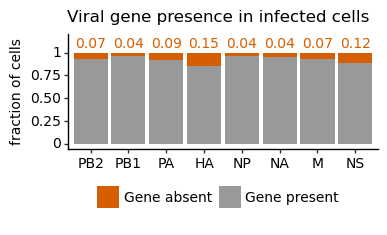

<ggplot: (8765063941039)>

In [12]:
gene_absence_file = figure_dir+'/'+'gene_absence_plot.svg'

gene_absence_plot = (
    p9.ggplot(gene_absence_rate,
              p9.aes(x='gene',
                     y='fraction_cells',
                     fill='gene_present')) +
    p9.geom_bar(stat='identity') +
    p9.geom_text(data=gene_absence_rate.query('gene_present == "Gene absent"'),
           mapping=p9.aes(x='gene',
                          y=1.1,
                          label='fraction_cells'),
                          format_string='{:.2f}',
                          size=10,
                          color=CBPALETTE[6]) +
    p9.ggtitle('Viral gene presence in infected cells') +
    p9.labs(x = '', y='fraction of cells') +
    p9.scale_y_continuous(limits=[0,1.15],
                          breaks=[0,0.25,0.5,0.75,1])+
    p9.theme(figure_size=(4, 1.5),
       plot_title=p9.element_text(size=12),
       axis_title=p9.element_text(size=10),
       axis_text=p9.element_text(size=10, color="black"),
       legend_position='bottom',
       legend_box_spacing=0.2,
       legend_title=p9.element_blank(),
       legend_text=p9.element_text(size=10)) +
    p9.scale_fill_manual([CBPALETTE[6],CBPALETTE[0]]))

gene_absence_plot.save(filename = gene_absence_file)
display(gene_absence_plot)

### Make composite Fig 2
Make a composite figure showing viral transcription, number of viral genes per cell, and rate of viral gene absence.

In [13]:
fig2_file = figure_dir+'/'+'fig2.svg'

fig2 = (Figure("27cm", "16cm",
       Panel(
#            Grid(20, 20),
           SVG(viral_transcription_file),
           Text("A", 5, 15, size=14)).scale(2),
       Panel(
           SVG(genes_per_cell_file),
           Text("B", 5, 15, size=14)).scale(2).move(560,0),
       Panel(
           SVG(gene_absence_file),
           Text("C", 5, 15, size=14)).scale(2).move(0,300),
       ))
display(fig2)
fig2.save(fig2_file)

### Plot viral gene presence or absence raw data
For each single infected cell, plot the expression of each viral gene relative to total viral expression. Color by whether gene was called as present or absent.

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 4 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/gene_expression_plot.svg
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10


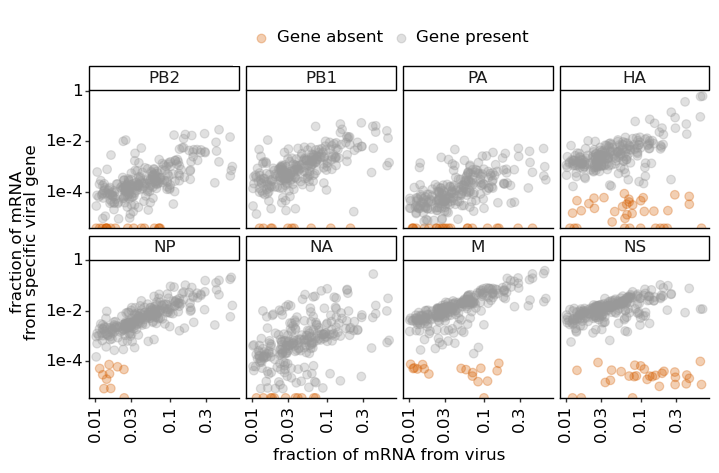

<ggplot: (8765063866010)>

In [14]:
gene_expression_file = figure_dir+'/'+'gene_expression_plot.svg'

gene_expression_plot = (
    p9.ggplot(viral_genes_by_cell,
               p9.aes(x='frac_viral_UMIs',
                      y='frac_gene_UMIs',
                      color='gene_present')) +
    p9.geom_point(alpha=0.3, size=3) +
    p9.facet_wrap('~gene', ncol=4) +
    p9.labs(x='fraction of mRNA from virus',
            y='fraction of mRNA\nfrom specific viral gene') +
    p9.scale_x_log10(breaks=[0.01,0.03,0.1,0.3]) +
    p9.scale_y_log10(breaks=[1e-4,1e-2,1]) +
    p9.theme(figure_size=(8, 4),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=12, color="black"),
             axis_text_x=p9.element_text(rotation=90),
             legend_position='top',
             legend_box_spacing=0,
             legend_title=p9.element_blank(),
             legend_text=p9.element_text(size=12),
             strip_text=p9.element_text(size=12)) +
    p9.scale_color_manual([CBPALETTE[6],CBPALETTE[0]]))

gene_expression_plot.save(filename = gene_expression_file)
display(gene_expression_plot)

## Plot viral transcription in fully-sequenced cells
For later analyses, I will require the cells to have PacBio sequencing information for all expressed viral genes, so that we can call consensus genomes. I want to see how viral transcription activity is associated with our ability to fully sequence a viral genome.


/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3.5 x 1.75 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/fully_sequenced_plot.svg


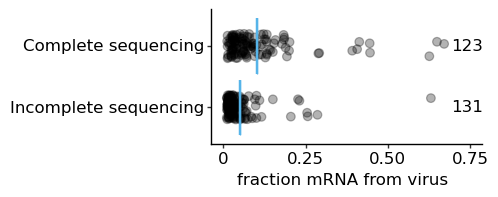

<ggplot: (8765053163710)>

In [15]:
fully_sequenced_file = figure_dir+'/'+'fully_sequenced_plot.svg'

fully_sequenced_plot = (
    p9.ggplot(wt_infected_cells,
               p9.aes(x='virus_fully_sequenced',
                      y='frac_viral_UMIs')) +
    p9.geom_jitter(alpha=0.3, size=3, width=0.2) +
    p9.stat_summary(fun_y=np.mean, 
                    fun_ymin=np.mean,
                    fun_ymax=np.mean,
                    geom='crossbar',
                    width=0.9,
                    color=CBPALETTE[2]) +
    p9.geom_text(data=wt_infected_cells.groupby('virus_fully_sequenced').nunique().reset_index(),
                 mapping=p9.aes(y=0.74,
                                label='cell_barcode'),
                 size=12) +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction mRNA from virus') +
    p9.scale_y_continuous(limits=[0,0.75], breaks=[0,0.25,0.5,0.75]) +
    p9.scale_x_discrete(labels=['Incomplete sequencing', 'Complete sequencing']) +
    p9.theme(figure_size=(3.5, 1.75),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=12, color="black")))

fully_sequenced_plot.save(filename = fully_sequenced_file)
display(fully_sequenced_plot)

Now, generate a dataframe that is a subset of `wt_infected_cells`, containing just cells with complete PacBio sequencing of all expressed viral genes.

In [16]:
fully_sequenced_cells = (
    wt_infected_cells
    .query('virus_fully_sequenced == True'))
display(fully_sequenced_cells)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,viral_barcodes_fluNA,freq_supernatant_fluHA,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded
3,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,23,...,CTCGTTTTCGGAGTAC; GACTATCTAATTGAGG,0.003532,0.000135,0.000165,0.00002,False,PA,True,True,sequenced and barcoded
4,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,82,...,TTTACTTTAAGTGCTT,0.00001,0.00001,0.00001,0.00001,True,,True,True,sequenced and barcoded
5,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,4204,...,AGTTATTGGTTGGATA,0.00002,0.000971,0.00002,0.000022,True,,True,True,sequenced and barcoded
10,AAGGAATAGATTGAGT,infected,wt,51455,1667,0.032397,6,3,435,99,...,TCGGTGGATAACCTTG,<NA>,0.00001,<NA>,0.00001,False,HA; PB2,True,False,sequenced
11,AAGGAATAGCATCGAG,infected,wt,91039,3192,0.035062,8,114,1262,48,...,CTGTTGTTCTTTACCA,0.00001,0.000072,0.000202,0.000165,True,,True,True,sequenced and barcoded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,TTGAGTGTCCTGGGTG,infected,wt,43013,8648,0.201055,8,795,2317,82,...,GTATTTGCAAAAAATG,0.00013,0.000904,0.00001,0.000014,True,,True,True,sequenced and barcoded
404,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,30,...,GAGCTCCTGTATTGCC,0.00001,0.00001,0.00001,0.00001,False,PA,True,True,sequenced and barcoded
405,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,71,...,TAAAAAATGTCTCATG,0.001014,0.001284,0.000154,0.000015,True,,True,True,sequenced and barcoded
408,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,219,...,GGTATCAGTTATTGTT,0.00001,0.00001,0.00001,0.00001,False,NS; PB1,True,True,sequenced and barcoded


### Aggregate mutation information
Viral mutation information from the PacBio sequencing is currently spread across many columns (one for each gene). I want to aggregate all viral mutaiton information into a single column so that I can display this on plots in the future. I will also annotate cells by whether they have non-synonymous mutations.

In [17]:
def viral_mutations(row):
    row_dict = row.to_dict()
    mutations = []
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                mutations.append(f"{gene}: {val}")
    return ", ".join(mutations)

def nonsynonymous_mutations(row):
    row_dict = row.to_dict()
    nonsynonymous_mutations = []
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                for x in val.split(' '):
                    if "synonymous" in x:
                        pass
                    elif "noncoding" in x:
                        pass
                    else:
                        nonsynonymous_mutations.append(f"{gene}: {x}")
    return ", ".join(nonsynonymous_mutations)

def nonsynonymous_mutation_count(row):
    row_dict = row.to_dict()
    nonsynonymous_mutation_count = 0
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                for x in val.split(' '):
                    if "synonymous" in x:
                        pass
                    elif "noncoding" in x:
                        pass
                    else:
                        nonsynonymous_mutation_count += 1
    return nonsynonymous_mutation_count

def mutation_support(row):
    row_dict = row.to_dict()
    support_vals = []
    for key, val in row_dict.items():
        if re.fullmatch("mutation_support_flu\w+", key) and val:
            gene = key.replace("mutation_support_flu", "")
            if val != "Not Applicable":
                support_vals.append(f"{gene}: {val}")
    return ", ".join(support_vals)

def mutated_genes(row):
    row_dict = row.to_dict()
    mutated_genes = []
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                mutated_genes.append(gene)
    return ", ".join(mutated_genes)

def label_cells(row):
    cell_label = None
    if row['all_viral_genes'] == True:
        if row['has_nonsynonymous_mutations'] == False:
            cell_label = "Complete unmutated genome"
        else:
            cell_label = "Complete mutated genome"
    elif row['all_viral_genes'] == False:
        if row['has_nonsynonymous_mutations'] == False:
            cell_label = "Missing viral gene(s)"
        else:
            cell_label = "Missing viral gene(s) and\nnon-synonymous mutations"
    return cell_label

fully_sequenced_cells = (
    fully_sequenced_cells
    .assign(
        viral_mutations=lambda x: x.apply(viral_mutations, axis=1),
        nonsynonymous_mutations=lambda x: x.apply(nonsynonymous_mutations, axis=1),
        mutation_support=lambda x: x.apply(mutation_support, axis=1),
        mutated_genes=lambda x: x.apply(mutated_genes, axis=1),
        has_mutations=lambda x: x["mutated_genes"].astype(bool),
        has_nonsynonymous_mutations=lambda x: x["nonsynonymous_mutations"].astype(bool),
        nonsynonymous_mutation_count=lambda x: x.apply(nonsynonymous_mutation_count, axis=1),
        cell_label=lambda x: x.apply(label_cells, axis=1).astype('category')
    )
)
display(fully_sequenced_cells)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,all_barcoded_genes,sequenced_and_barcoded,viral_mutations,nonsynonymous_mutations,mutation_support,mutated_genes,has_mutations,has_nonsynonymous_mutations,nonsynonymous_mutation_count,cell_label
3,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,23,...,True,sequenced and barcoded,PB2: del168to2007 del2097to2106,"PB2: del168to2007, PB2: del2097to2106",PB2: 1597/1611 1601/1611,PB2,True,True,2,Missing viral gene(s) and\nnon-synonymous muta...
4,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,82,...,True,sequenced and barcoded,,,,,False,False,0,Complete unmutated genome
5,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,4204,...,True,sequenced and barcoded,"M: A111C_synonymous, NA: del39to1256, NS: G550...","NA: del39to1256, NS: G550A_G184R, PA: A937C_T313P","M: 436/472, NA: 1483/1550, NS: 48/50, PA: 7/9","M, NA, NS, PA",True,True,3,Complete mutated genome
10,AAGGAATAGATTGAGT,infected,wt,51455,1667,0.032397,6,3,435,99,...,False,sequenced,,,,,False,False,0,Missing viral gene(s)
11,AAGGAATAGCATCGAG,infected,wt,91039,3192,0.035062,8,114,1262,48,...,True,sequenced and barcoded,"NA: del43to43, PB2: T650A_F217Y","NA: del43to43, PB2: T650A_F217Y","NA: 14/14, PB2: 4/4","NA, PB2",True,True,2,Complete mutated genome
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,TTGAGTGTCCTGGGTG,infected,wt,43013,8648,0.201055,8,795,2317,82,...,True,sequenced and barcoded,,,,,False,False,0,Complete unmutated genome
404,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,30,...,True,sequenced and barcoded,HA: A954G_synonymous,,HA: 15/16,HA,True,False,0,Missing viral gene(s)
405,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,71,...,True,sequenced and barcoded,,,,,False,False,0,Complete unmutated genome
408,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,219,...,True,sequenced and barcoded,HA: T465A_H155Q,HA: T465A_H155Q,HA: 85/90,HA,True,True,1,Missing viral gene(s) and\nnon-synonymous muta...


### Viral genotype statistics
Calculate how many infected cells we characterized, how many conensus viral sequences have mutations, and what kinds of mutations they carry.

In [18]:
mutated_cell_counts = (
    pd.DataFrame(
        fully_sequenced_cells.groupby(['cell_label'])
        ['cell_barcode'].nunique()).reset_index()
    .rename(columns={'cell_barcode': 'n_cells'}))

mutated_cell_counts['cell_label'] = (
    mutated_cell_counts['cell_label']
    .cat.reorder_categories(
        ['Missing viral gene(s) and\nnon-synonymous mutations', 'Missing viral gene(s)', 
        'Complete mutated genome', 'Complete unmutated genome']))

display(mutated_cell_counts)

,cell_label,n_cells
0,Complete mutated genome,30
1,Complete unmutated genome,41
2,Missing viral gene(s),33
3,Missing viral gene(s) and\nnon-synonymous muta...,19


### Plot viral genotype statistics

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 2 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/mutated_cell_counts_plot.svg


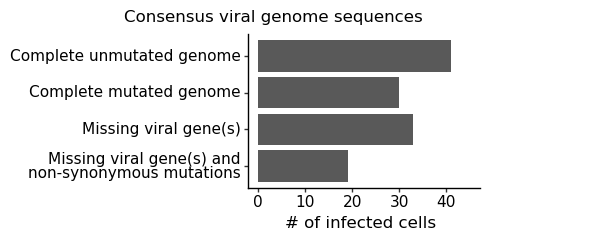

<ggplot: (8765053079176)>

In [19]:
mutated_cell_counts_file = figure_dir+'/'+'mutated_cell_counts_plot.svg'

mutated_cell_counts_plot = (
    p9.ggplot(mutated_cell_counts,
              p9.aes(x='cell_label',
                     y='n_cells',
                     width=0.85)) +
    p9.geom_bar(stat='identity') +
    p9.coord_flip() +
    p9.ggtitle('Consensus viral genome sequences                                 ') +
    p9.labs(x = '', y='# of infected cells') +
    p9.ylim([0,45]) +
    p9.theme(figure_size=(3, 2),
       plot_title=p9.element_text(size=12),
       axis_title=p9.element_text(size=12),
       axis_text=p9.element_text(size=11, color="black")))

mutated_cell_counts_plot.save(filename = mutated_cell_counts_file)
display(mutated_cell_counts_plot)

### Plot number of non-synonymous mutations per cell.

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 2 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/mutations_per_cell.svg


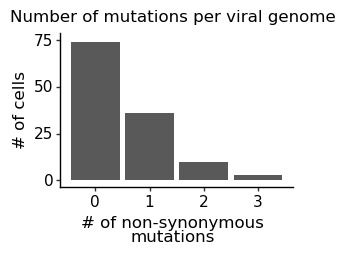

<ggplot: (8765053862888)>

In [20]:
mutations_per_cell_file = figure_dir+'/'+'mutations_per_cell.svg'

mutations_per_cell_plot = (
    p9.ggplot(
        fully_sequenced_cells,
        p9.aes(x='nonsynonymous_mutation_count')) +
    p9.geom_bar() +
    p9.ggtitle(f'Number of mutations per viral genome') +
    p9.labs(x='# of non-synonymous\nmutations',
            y='# of cells') +
    p9.scale_y_continuous(limits=[0,75], breaks=[0,25,50,75]) +
    p9.theme(figure_size=(3, 2),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=11, color="black"),
             legend_box_spacing=0.2,
             legend_title=p9.element_blank()))
mutations_per_cell_plot.save(filename = mutations_per_cell_file)
display(mutations_per_cell_plot)

### Make composite Fig 3
Make a composite figure showing viral genotypes and number of mutations per genome.

In [21]:
fig3_file = figure_dir+'/'+'fig3.svg'

fig3 = (Figure("25cm", "7cm",
       Panel(
#           Grid(20, 20),
           SVG(mutated_cell_counts_file),
           Text("A", 5, 15, size=14)).scale(1.5),
       Panel(
           SVG(mutations_per_cell_file).move(15,0),
           Text("B", 5, 15, size=14)).scale(1.5).move(500,0),
       ))
display(fig3)
fig3.save(fig3_file)

## Plots of cells with complete progeny measurements
Next, I will calculate the contribution of each infected cell to the progeny population. I will calculate this as the geometric mean of the HA and NA barcode frequencies. I will subset the data and plot the relationship between viral transcription and progeny production for cells with both barcoded viral genes and complete PacBio data.


### Plot viral transcription in cells that express both barcoded genes
How does total viral transcription correlate with expressing both viral genes needed for progeny contribution meausrements?

In [22]:
barcoded_cells = wt_infected_cells.query("all_barcoded_genes")
display(barcoded_cells)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,viral_barcodes_fluNA,freq_supernatant_fluHA,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded
1,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,8,319,1582,31,...,GTAGGCGATAAGTGGA,0.000076,0.000076,0.00001,0.00001,True,,False,True,barcoded
3,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,23,...,CTCGTTTTCGGAGTAC; GACTATCTAATTGAGG,0.003532,0.000135,0.000165,0.00002,False,PA,True,True,sequenced and barcoded
4,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,82,...,TTTACTTTAAGTGCTT,0.00001,0.00001,0.00001,0.00001,True,,True,True,sequenced and barcoded
5,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,4204,...,AGTTATTGGTTGGATA,0.00002,0.000971,0.00002,0.000022,True,,True,True,sequenced and barcoded
7,AACTTCTGTGAGACGT,infected,wt,137078,2955,0.021557,8,100,845,8,...,GATAAGTATGACAAAG,0.00001,0.00001,0.00001,0.00001,True,,False,True,barcoded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,30,...,GAGCTCCTGTATTGCC,0.00001,0.00001,0.00001,0.00001,False,PA,True,True,sequenced and barcoded
405,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,71,...,TAAAAAATGTCTCATG,0.001014,0.001284,0.000154,0.000015,True,,True,True,sequenced and barcoded
407,TTTACCAGTCGCTTAA,infected,wt,114567,1434,0.012517,7,125,609,15,...,ATTTGGATGTAGGGGC; TTGGAGGAGACCCGTG,0.000106,0.001222,0.00002,0.000029,False,PA,False,True,barcoded
408,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,219,...,GGTATCAGTTATTGTT,0.00001,0.00001,0.00001,0.00001,False,NS; PB1,True,True,sequenced and barcoded


/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3.5 x 1.75 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/barcoded_cells_plot.svg


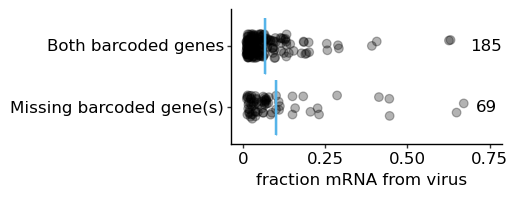

<ggplot: (8765053073866)>

In [23]:
barcoded_cells_file = figure_dir+'/'+'barcoded_cells_plot.svg'

barcoded_cells_plot = (
    p9.ggplot(wt_infected_cells,
               p9.aes(x='all_barcoded_genes',
                      y='frac_viral_UMIs')) +
    p9.geom_jitter(alpha=0.3, size=3, width=0.2) +
    p9.stat_summary(fun_y=np.mean, 
                    fun_ymin=np.mean,
                    fun_ymax=np.mean,
                    geom='crossbar',
                    width=0.9,
                    color=CBPALETTE[2]) +
    p9.geom_text(data=wt_infected_cells.groupby('all_barcoded_genes').nunique().reset_index(),
                 mapping=p9.aes(y=0.74,
                                label='cell_barcode'),
                 size=12) +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction mRNA from virus') +
    p9.scale_y_continuous(limits=[0,0.75], breaks=[0,0.25,0.5,0.75]) +
    p9.scale_x_discrete(labels=['Missing barcoded gene(s)', 'Both barcoded genes']) +
    p9.theme(figure_size=(3.5, 1.75),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=12, color="black")))

barcoded_cells_plot.save(filename = barcoded_cells_file)
display(barcoded_cells_plot)

### Select subset of cells with complete sequencing and both barcoded viral genes
In the next section, I will calculate progeny contributions for cells that have complete long-read sequencing and express both barcoded viral genes. I want to count how many cells meet these criteria, and how many fail one or both of these criteria.

In [24]:
sequenced_barcoded_cell_counts = (wt_infected_cells
        .groupby("sequenced_and_barcoded")
        .aggregate(n_cells=pd.NamedAgg("cell_barcode", "count"))
        .reset_index()
)
sequenced_barcoded_cell_counts['sequenced_and_barcoded'] = (
    sequenced_barcoded_cell_counts['sequenced_and_barcoded']
    .astype('category')
    .cat
    .reorder_categories(['not sequenced or barcoded',
              'barcoded',
              'sequenced',
              'sequenced and barcoded'])
)
sequenced_barcoded_cell_counts['selected_cells'] = (
    sequenced_barcoded_cell_counts['sequenced_and_barcoded'] == \
    "sequenced and barcoded"
)
sequenced_barcoded_cells = fully_sequenced_cells.query('sequenced_and_barcoded == "sequenced and barcoded"')
display(sequenced_barcoded_cells)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,all_barcoded_genes,sequenced_and_barcoded,viral_mutations,nonsynonymous_mutations,mutation_support,mutated_genes,has_mutations,has_nonsynonymous_mutations,nonsynonymous_mutation_count,cell_label
3,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,23,...,True,sequenced and barcoded,PB2: del168to2007 del2097to2106,"PB2: del168to2007, PB2: del2097to2106",PB2: 1597/1611 1601/1611,PB2,True,True,2,Missing viral gene(s) and\nnon-synonymous muta...
4,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,82,...,True,sequenced and barcoded,,,,,False,False,0,Complete unmutated genome
5,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,4204,...,True,sequenced and barcoded,"M: A111C_synonymous, NA: del39to1256, NS: G550...","NA: del39to1256, NS: G550A_G184R, PA: A937C_T313P","M: 436/472, NA: 1483/1550, NS: 48/50, PA: 7/9","M, NA, NS, PA",True,True,3,Complete mutated genome
11,AAGGAATAGCATCGAG,infected,wt,91039,3192,0.035062,8,114,1262,48,...,True,sequenced and barcoded,"NA: del43to43, PB2: T650A_F217Y","NA: del43to43, PB2: T650A_F217Y","NA: 14/14, PB2: 4/4","NA, PB2",True,True,2,Complete mutated genome
14,AATCGTGGTACTGAGG,infected,wt,168506,6655,0.039494,7,1417,2295,46,...,True,sequenced and barcoded,NA: A1634T_noncoding,,NA: 28/29,NA,True,False,0,Missing viral gene(s)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,TTGAGTGTCCTGGGTG,infected,wt,43013,8648,0.201055,8,795,2317,82,...,True,sequenced and barcoded,,,,,False,False,0,Complete unmutated genome
404,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,30,...,True,sequenced and barcoded,HA: A954G_synonymous,,HA: 15/16,HA,True,False,0,Missing viral gene(s)
405,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,71,...,True,sequenced and barcoded,,,,,False,False,0,Complete unmutated genome
408,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,219,...,True,sequenced and barcoded,HA: T465A_H155Q,HA: T465A_H155Q,HA: 85/90,HA,True,True,1,Missing viral gene(s) and\nnon-synonymous muta...


### Plot number of cells with or without complete sequencing and both barcoded genes

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3.6 x 1.75 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/selected_cells_plot.svg


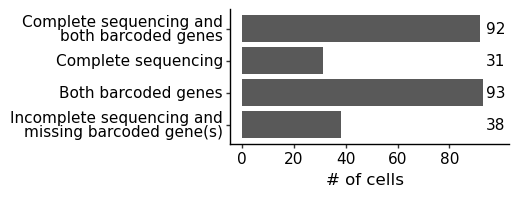

<ggplot: (8765053038749)>

In [25]:
selected_cells_file = figure_dir+'/'+'selected_cells_plot.svg'

selected_cells_plot = (
    p9.ggplot(sequenced_barcoded_cell_counts,
               p9.aes(x='sequenced_and_barcoded',
                      y='n_cells',
                      width=0.85)) +
    p9.geom_bar(stat='identity', position='dodge') +
    p9.geom_text(p9.aes(y=98, label='n_cells'), size=11) +
    p9.labs(x='',
            y='# of cells') +
    p9.coord_flip() +
    p9.scale_y_continuous(limits=[0,98], breaks=[0,20,40,60,80]) +
    p9.scale_x_discrete(labels=["Incomplete sequencing and\nmissing barcoded gene(s)",
                                "Both barcoded genes",
                                "Complete sequencing",
                                "Complete sequencing and\nboth barcoded genes"]) +
    p9.theme(figure_size=(3.6, 1.75),
       plot_title=p9.element_text(size=12),
       axis_title=p9.element_text(size=12),
       axis_text=p9.element_text(size=11, color="black")))

selected_cells_plot.save(filename = selected_cells_file)
display(selected_cells_plot)

### Plot viral transcription in cells with complete sequencing and both barcoded viral genes
Do the cells that meet these criteria have a different distribution of viral transcription, or are we subsampling the data in a fairly non-biased way?

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3.5 x 1.75 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/sequenced_and_barcoded_plot.svg


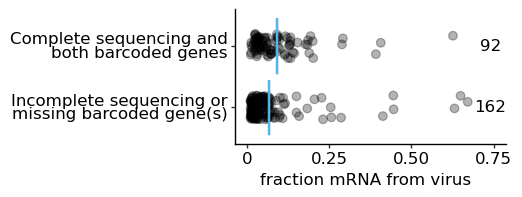

<ggplot: (8765052982083)>

In [26]:
sequenced_and_barcoded_file = figure_dir+'/'+'sequenced_and_barcoded_plot.svg'

sequenced_and_barcoded_plot = (
    p9.ggplot(wt_infected_cells,
               p9.aes(x='factor(sequenced_and_barcoded == "sequenced and barcoded")',
                      y='frac_viral_UMIs')) +
    p9.geom_jitter(alpha=0.3, size=3, width=0.2) +
    p9.stat_summary(fun_y=np.mean, 
                    fun_ymin=np.mean,
                    fun_ymax=np.mean,
                    geom='crossbar',
                    width=0.9,
                    color=CBPALETTE[2]) +
    p9.geom_text(data=pd.DataFrame(sequenced_barcoded_cell_counts.groupby('selected_cells')['n_cells'].sum().reset_index()),
                 mapping=p9.aes(
                     x='selected_cells',
                     y=0.74,
                     label='n_cells'),
                 size=12) +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction mRNA from virus') +
    p9.scale_y_continuous(limits=[0,0.75], breaks=[0,0.25,0.5,0.75]) +
    p9.scale_x_discrete(labels=['Incomplete sequencing or\nmissing barcoded gene(s)', 'Complete sequencing and\nboth barcoded genes']) +
    p9.theme(figure_size=(3.5, 1.75),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=12, color="black")))

sequenced_and_barcoded_plot.save(filename = sequenced_and_barcoded_file)
display(sequenced_and_barcoded_plot)

### Make composite Fig S4
Assemble a composite figure showing how many cells are sequenced completely, have both barcoded viral genes, and the relationship of these criteria to total viral transcription.

In [27]:
figS4_file = figure_dir+'/'+'figS4.svg'

figS4 = (Figure("27cm", "11cm",
       Panel(
#           Grid(20, 20),
           SVG(fully_sequenced_file).move(15,10),
           Text("A", 0, 20, size=18)),
       Panel(
           SVG(barcoded_cells_file).move(0,10),
           Text("B", 0, 20, size=18)).move(380,0),
       Panel(
           SVG(selected_cells_file).move(0,20),
           Text("C", 0, 20, size=18)).move(0,150),
       Panel(
           SVG(sequenced_and_barcoded_file).move(10,20),
           Text("D", 0, 20, size=18)).move(380,150),
       )).scale(1.3)
display(figS4)
figS4.save(figS4_file)

### Calculate progeny contribution
Normalize the the progeny viral barcode frequences among source and gene (e.g. 'supernatant fluHA'). Take the geometric mean of both barcoded genes to estimate the progeny contribution for each infected cell:

In [28]:
for condition in ["supernatant", "second_infection"]:
    for gene in barcoded_genes:
        # normalize among selected cells and within barcoded gene
        col = f"freq_{condition}_{gene}"
        sequenced_barcoded_cells[col] = (
            sequenced_barcoded_cells[col] /
            sequenced_barcoded_cells[col].sum()
        )
    # calculate geometric mean of normalized values
    mean_col = f"freq_{condition}"
    sequenced_barcoded_cells[mean_col] = (
        sequenced_barcoded_cells[f"{mean_col}_fluHA"]
        * sequenced_barcoded_cells[f"{mean_col}_fluNA"]
    )**(1 / 2)
    sequenced_barcoded_cells[mean_col] = (
        sequenced_barcoded_cells[mean_col] /
        sequenced_barcoded_cells[mean_col].sum()
    )

display(sequenced_barcoded_cells)

/tmp/ipykernel_72059/1543506444.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_72059/1543506444.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_72059/1543506444.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_72059

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,viral_mutations,nonsynonymous_mutations,mutation_support,mutated_genes,has_mutations,has_nonsynonymous_mutations,nonsynonymous_mutation_count,cell_label,freq_supernatant,freq_second_infection
3,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,23,...,PB2: del168to2007 del2097to2106,"PB2: del168to2007, PB2: del2097to2106",PB2: 1597/1611 1601/1611,PB2,True,True,2,Missing viral gene(s) and\nnon-synonymous muta...,0.012422,0.001217
4,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,82,...,,,,,False,False,0,Complete unmutated genome,0.00018,0.000212
5,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,4204,...,"M: A111C_synonymous, NA: del39to1256, NS: G550...","NA: del39to1256, NS: G550A_G184R, PA: A937C_T313P","M: 436/472, NA: 1483/1550, NS: 48/50, PA: 7/9","M, NA, NS, PA",True,True,3,Complete mutated genome,0.002508,0.000443
11,AAGGAATAGCATCGAG,infected,wt,91039,3192,0.035062,8,114,1262,48,...,"NA: del43to43, PB2: T650A_F217Y","NA: del43to43, PB2: T650A_F217Y","NA: 14/14, PB2: 4/4","NA, PB2",True,True,2,Complete mutated genome,0.000483,0.003879
14,AATCGTGGTACTGAGG,infected,wt,168506,6655,0.039494,7,1417,2295,46,...,NA: A1634T_noncoding,,NA: 28/29,NA,True,False,0,Missing viral gene(s),0.00018,0.000212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,TTGAGTGTCCTGGGTG,infected,wt,43013,8648,0.201055,8,795,2317,82,...,,,,,False,False,0,Complete unmutated genome,0.006157,0.000249
404,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,30,...,HA: A954G_synonymous,,HA: 15/16,HA,True,False,0,Missing viral gene(s),0.00018,0.000212
405,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,71,...,,,,,False,False,0,Complete unmutated genome,0.020534,0.001035
408,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,219,...,HA: T465A_H155Q,HA: T465A_H155Q,HA: 85/90,HA,True,True,1,Missing viral gene(s) and\nnon-synonymous muta...,0.00018,0.000212


In [29]:
# Placeholder. Correlation betweeen physical progeny virions (supernatant) and infectious progeny virions (second_infection).

### Plot full viral genomes of infected cells with complete PacBio coverage
To generate this plot, we needed to provide progeny contribution measurements where possible. This is why this task is performed **after** estimating progeny contributions. Cells with complete PacBio data without progeny contribution measurements will have null value.

In [30]:
# Bring in progeny production measurements when available
fully_sequenced_cells_CSV = 'results/pacbio/fully_sequenced_cells.csv'

fully_sequenced_cells = pd.merge(
    left=fully_sequenced_cells,
    right=sequenced_barcoded_cells[['cell_barcode', 'freq_supernatant', 'freq_second_infection']],
    on='cell_barcode',
    how='left',
    validate='one_to_one'
)
display(fully_sequenced_cells)
print(f"Writing fully sequenced cells data to CSV: {fully_sequenced_cells_CSV}")
fully_sequenced_cells.to_csv(fully_sequenced_cells_CSV)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,viral_mutations,nonsynonymous_mutations,mutation_support,mutated_genes,has_mutations,has_nonsynonymous_mutations,nonsynonymous_mutation_count,cell_label,freq_supernatant,freq_second_infection
0,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,23,...,PB2: del168to2007 del2097to2106,"PB2: del168to2007, PB2: del2097to2106",PB2: 1597/1611 1601/1611,PB2,True,True,2,Missing viral gene(s) and\nnon-synonymous muta...,0.012422,0.001217
1,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,82,...,,,,,False,False,0,Complete unmutated genome,0.00018,0.000212
2,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,4204,...,"M: A111C_synonymous, NA: del39to1256, NS: G550...","NA: del39to1256, NS: G550A_G184R, PA: A937C_T313P","M: 436/472, NA: 1483/1550, NS: 48/50, PA: 7/9","M, NA, NS, PA",True,True,3,Complete mutated genome,0.002508,0.000443
3,AAGGAATAGATTGAGT,infected,wt,51455,1667,0.032397,6,3,435,99,...,,,,,False,False,0,Missing viral gene(s),NaN,NaN
4,AAGGAATAGCATCGAG,infected,wt,91039,3192,0.035062,8,114,1262,48,...,"NA: del43to43, PB2: T650A_F217Y","NA: del43to43, PB2: T650A_F217Y","NA: 14/14, PB2: 4/4","NA, PB2",True,True,2,Complete mutated genome,0.000483,0.003879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,TTGAGTGTCCTGGGTG,infected,wt,43013,8648,0.201055,8,795,2317,82,...,,,,,False,False,0,Complete unmutated genome,0.006157,0.000249
119,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,30,...,HA: A954G_synonymous,,HA: 15/16,HA,True,False,0,Missing viral gene(s),0.00018,0.000212
120,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,71,...,,,,,False,False,0,Complete unmutated genome,0.020534,0.001035
121,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,219,...,HA: T465A_H155Q,HA: T465A_H155Q,HA: 85/90,HA,True,True,1,Missing viral gene(s) and\nnon-synonymous muta...,0.00018,0.000212


Writing fully sequenced cells data to CSV: results/pacbio/fully_sequenced_cells.csv


### Generate viral genome plot using R script
There is an R script that generates the viral genomes plot using `gggenes`. We call that here using `subprocess.call`.

In [31]:
# call R script to generate viral genomes plot
viral_genomes_file = figure_dir+'/'+'viral_genomes_plot.pdf'
rscript_file = "scripts/viral_genomes_plot.R"
subprocess.call(" ".join(["Rscript", rscript_file, fully_sequenced_cells_CSV, viral_genomes_file]), shell = True)

Warning message:
package ‘ggplot2’ was built under R version 4.1.3 
Warning message:
package ‘ggnewscale’ was built under R version 4.1.2 
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


0